# Comparación entre algoritmos Dijkstra y A*

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import sys
import random
import math
import time

In [2]:
df_aristas = pd.read_csv("data-ejemplo/aristas.csv")
df_aristas

,id,source,target,length,foot,car_forward,car_backward,bike_forward,bike_backward,wkt
0,104851469,1209261299,5394543995,147.433722,1,4,0,2,0,"LINESTRING(-75.2164990 -12.0585078, -75.216908..."
1,104851469,5394543995,4150228762,123.394352,1,4,0,2,0,"LINESTRING(-75.2172212 -12.0573874, -75.217328..."
2,104851469,4150228762,1209256646,86.068643,1,4,0,2,0,"LINESTRING(-75.2178111 -12.0564409, -75.218202..."
3,104851469,1209256646,5394544018,99.195577,1,4,0,2,0,"LINESTRING(-75.2182021 -12.0557689, -75.218673..."
4,104851469,5394544018,1043251501,701.253849,1,4,0,2,0,"LINESTRING(-75.2186738 -12.0550065, -75.219140..."
...,...,...,...,...,...,...,...,...,...,...
79,559267886,1209259338,5394543998,100.946930,1,1,1,2,2,"LINESTRING(-75.2195249 -12.0565551, -75.219046..."
80,559267887,5394544004,5394544003,56.109782,1,1,1,2,2,"LINESTRING(-75.2214079 -12.0570883, -75.221091..."
81,559267888,5394544009,5394544007,107.215487,1,1,1,2,2,"LINESTRING(-75.2213640 -12.0581984, -75.220599..."
82,559267888,5394544007,5394544005,108.105147,1,1,1,2,2,"LINESTRING(-75.2205667 -12.0576398, -75.220514..."


In [3]:
df_vertices = pd.read_csv("data-ejemplo/nodos.csv")
df_vertices

,id,lon,lat
0,1209250656,-75.217439,-12.055316
1,1209259338,-75.219525,-12.056555
2,5394543995,-75.217221,-12.057387
3,1209256161,-75.219088,-12.056291
4,5394543983,-75.220496,-12.056532
...,...,...,...
57,5394544003,-75.221092,-12.057486
58,5394543993,-75.220840,-12.059021
59,5394543977,-75.218573,-12.056720
60,5394544001,-75.219448,-12.057576


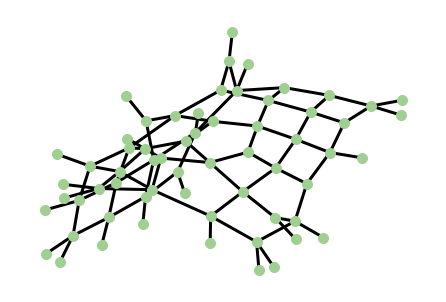

In [4]:
options = {
    'node_color': '#A0D091',
    'node_size': 100,
    'width': 3,
    'font_weight': 'bold',
    #'with_labels': True,
}
grafo = nx.Graph()
for i in range(df_aristas.shape[0]):
  grafo.add_edge(df_aristas["source"][i], df_aristas["target"][i])
nx.draw(grafo, **options)

In [5]:
grafo.edges

EdgeView([(1209261299, 5394543995), (5394543995, 4150228762), (5394543995, 5394543996), (4150228762, 1209256646), (4150228762, 5396339074), (4150228762, 1209249131), (1209256646, 5394544018), (1209256646, 1209250656), (1209256646, 1209251752), (5394544018, 1043251501), (5394544018, 5453701874), (5394544018, 1209248504), (1209248504, 5394544017), (1209248504, 1043251560), (1209248504, 1209251752), (5394544017, 5394544015), (5394544017, 5394533463), (5394544017, 1209256161), (5394544015, 5394544016), (5394544015, 5394533443), (5394544015, 1209254527), (5394544016, 5394547723), (5394544016, 5394533443), (5394544016, 5394543982), (5394547723, 5394543975), (5394547723, 5394533481), (5394547723, 5394533447), (5394543975, 5394533437), (5394543975, 5394533487), (5394543975, 5394533449), (1209248070, 5394533443), (5394533443, 5394533474), (1209254527, 1209256161), (1209254527, 1209259338), (1209249131, 5394543976), (1209249131, 1209251752), (1209249131, 5394543996), (1209251752, 1209256161), (1

## Clase grafo y clase vertice

In [6]:
class Vertex:
    def __init__(self, node,lon,lat,cont):
      rand = random.randrange(9000,100000)
      self.id = node
      self.adjacent = {}
      # Distancia infinito para todos los nodos (infinito es un random grande)
      self.distance = rand
      self.distanceG = rand
      self.distanceF = rand
      # Todos los nodos inician como no visitados    
      self.visited = False  
      # prev
      self.previous = None
      #longitud y latitud
      self.longitud = lon
      self.latitud = lat
      self.cont = cont #identificador unico para cada vertice (a parte del id)

    def agregar_vecino(self, neighbor, weight=0):
      self.adjacent[neighbor] = weight

    def obtener_conexiones(self):
      return self.adjacent.keys()  

    def obtener_id(self):
      return self.id

    def obtener_peso(self, neighbor):
      return self.adjacent[neighbor]

    def agregar_distancia(self, dist):
      self.distance = dist

    def obtener_distancia(self):
      return self.distance

    def agregar_distanciaG(self, dist):
      self.distanceG = dist

    def obtener_distanciaG(self):
      return self.distanceG

    def agregar_distanciaF(self, dist):
      self.distanceF = dist

    def obtener_distanciaF(self):
      return self.distanceF

    def obtener_lon(self):
      return self.longitud

    def obtener_lat(self):
      return self.latitud

    def agregar_previous(self, prev):
      self.previous = prev

    def visitado(self):
      self.visited = True

    def __str__(self):
      return str(self.id) + ' adjacent: ' + str([x.id for x in self.adjacent])

class Graph:
  def __init__(self):
    self.vert_dict = {}
    self.num_vertices = 0

  def __iter__(self):
    return iter(self.vert_dict.values())

  def agregar_vertice(self, node,lon,lat,cont):
    self.num_vertices = self.num_vertices + 1
    new_vertex = Vertex(node,lon,lat,cont)
    self.vert_dict[node] = new_vertex
    return new_vertex

  def obtener_vertice(self, n):
    if n in self.vert_dict:
      return self.vert_dict[n]
    else:
      return None

  def agregar_arista(self, frm, to, cost = 0):
    if frm not in self.vert_dict:
      self.agregar_vertice(frm)
    if to not in self.vert_dict:
      self.agregar_vertice(to)

    self.vert_dict[frm].agregar_vecino(self.vert_dict[to], cost)
    self.vert_dict[to].agregar_vecino(self.vert_dict[frm], cost)

  def obtener_vertices(self):
    return self.vert_dict.keys()

  def agregar_previous(self, u):
    self.previous = u

  def obtener_previous(self, u):
    return self.previous

## Algoritmo Dijkstra

In [7]:
def dijkstra(aGraph, start, target):
    '''Algoritmo de Dijkstra'''
    # distancia del nodo inicial = 0
    start.agregar_distancia(0)

    # se colocarán todas las tuplas (distancia,vertice) en una cola de prioridad (Q)
    Q = []
    dic = {} #diccionario donde almaceno id,vertice
    nodos_expandidos = 0
    for v in aGraph:
        dic[v.cont] = v
        Q.append((v.obtener_distancia(),v.cont))
    heapq.heapify(Q)
    #nodos_open = []
    while len(Q):
        nodos_expandidos +=1
        # Hacemos pop a la tupla (distancia, vertice) con menor distancia de Q
        uv = heapq.heappop(Q) #Se asigna y se elimina u de Q
        #nodos_open.append(uv)
        u = dic.get(uv[1]) #Se obtiene el vértice
        u.visitado()
        #Sale del algoritmo de Dijkstra
        if(u.id == target.id):
            u_copia = u
            camino = []
            camino.append(u_copia.id)
            if(u_copia.previous):
                while(u_copia.previous):
                    camino.append(u_copia.previous.id)
                    u_copia = u_copia.previous
                #print(u.obtener_distancia(), camino[::-1])
                #print(nodos_open)
                print("longitud camino mínimo: ",len(camino))
                print("vértices expandidos: ",nodos_expandidos)
                eficiencia = len(camino)/nodos_expandidos
                print("Eficiencia: ", eficiencia)
                return u.obtener_distancia(), camino[::-1]

        # Para cada vertice vecino v de u :
        for v in u.adjacent:
            if v.visited:
                continue
            new_dist = u.obtener_distancia() + u.obtener_peso(v)
            
            if new_dist < v.obtener_distancia():
                v.agregar_distancia(new_dist)
                v.agregar_previous(u)  

        #Refresh de la cola de prioridad
        # 1. Hacemos pop de todos los items
        while len(Q):
            heapq.heappop(Q)
        # 2. Actualizamos todos los vértices no visitados del grafo
        dic = {} #diccionario donde almaceno id,vertice
        for v in aGraph:
            if not v.visited:
                dic[v.cont] = v
                Q.append((v.obtener_distancia(),v.cont))
        heapq.heapify(Q)

In [8]:
g = Graph()
for i in range(df_vertices.shape[0]):
  g.agregar_vertice(df_vertices["id"][i], df_vertices["lon"][i], df_vertices["lat"][i],i)

for j in range(df_aristas.shape[0]):
  g.agregar_arista(df_aristas["source"][j],df_aristas["target"][j],df_aristas["length"][j])
inicio = time.time()
distancia, camino_min = dijkstra(g, g.obtener_vertice(1209250656), g.obtener_vertice(5394533442)) 
fin = time.time()
print("Tiempo: ",fin - inicio) 
print("Distancia mínima: ", distancia)
print("Camino:", camino_min)

longitud camino mínimo:  10
vértices expandidos:  52
Eficiencia:  0.19230769230769232
Tiempo:  0.002991914749145508
Distancia mínima:  777.7267723985442
Camino: [1209250656, 1209256646, 4150228762, 1209249131, 5394543976, 5394544002, 5394543992, 9427160616, 5394543997, 5394533442]


## Algoritmo A*

In [9]:
def h(x1,y1,x2,y2):
  '''Distancia Euclidea'''
  distance = ((x2 - x1)**2 + (y2 - y1)**2)**(1/2)
  return distance * 6371 *(math.pi/180)*1000

In [10]:
def AStar(aGraph, start, target):
    '''Algoritmo de A*'''
    # distancia del nodo inicial = 0
    start.agregar_distancia(0)
    start.agregar_distanciaG(0)
    start.agregar_distanciaF(h(start.longitud, start.latitud, target.longitud, target.latitud))
    # se colocarán todas las tuplas (distancia,vertice) en una cola de prioridad (Q)
    Q = []
    nodos_expandidos = 0
    dic = {} #diccionario donde almaceno id,vertice
    dic[start.cont] = start
    Q.append((start.obtener_distanciaF(),start.cont))
    heapq.heapify(Q)
    #nodos_open = []
    while len(Q):
        nodos_expandidos +=1
        # Hacemos pop a la tupla (distancia, vertice) con menor distancia de Q
        uv = heapq.heappop(Q) #Se asigna y se elimina u de Q
        #nodos_open.append(uv)
        u = dic.get(uv[1]) #Se obtiene el vértice
        u.visitado()
        #Sale del algoritmo de A*
        if(u.id == target.id):
            u_copia = u
            camino = []
            camino.append(u_copia.id)
            if(u_copia.previous):
                while(u_copia.previous):
                    camino.append(u_copia.previous.id)
                    u_copia = u_copia.previous
                #print(nodos_open)
                print("longitud camino mínimo: ",len(camino))
                print("vértices expandidos: ",nodos_expandidos)
                eficiencia = len(camino)/nodos_expandidos
                print("Eficiencia: ", eficiencia)
                return u.obtener_distanciaG(), camino[::-1]

        # Para cada vertice vecino v de u :
        for v in u.adjacent:
            if v.visited:
                continue
            temporalG = u.obtener_distanciaG() + u.obtener_peso(v)
            if temporalG < v.obtener_distanciaG():
                v.agregar_previous(u)
                v.agregar_distanciaG(temporalG)
                v.agregar_distanciaF(temporalG + h(v.longitud, v.latitud, target.longitud, target.latitud))
                if((v.distanceF,v.cont) not in Q):
                    dic[v.cont] = v
                    Q.append((v.distanceF,v.cont))

        #Refresh de la cola de prioridad Q
        valores = list(dic.values())
        # 1. Hacemos pop de todos los items
        while len(Q):
            heapq.heappop(Q)
        # 2. Actualizamos solo los vértices no visitados que están en Q, NO de todo el grafo
        dic = {}
        for v in aGraph:
            if v in valores:
                if not v.visited:
                    dic[v.cont] = v
                    Q.append((v.obtener_distanciaF(),v.cont))
        heapq.heapify(Q)

        
    

        

In [11]:
g = Graph()
for i in range(df_vertices.shape[0]):
  g.agregar_vertice(df_vertices["id"][i], df_vertices["lon"][i], df_vertices["lat"][i],i)

for j in range(df_aristas.shape[0]):
  g.agregar_arista(df_aristas["source"][j],df_aristas["target"][j],df_aristas["length"][j])

inicio = time.time()
distancia, camino_min = AStar(g, g.obtener_vertice(1209250656), g.obtener_vertice(5394533442))
fin = time.time()
print("Tiempo: ",fin - inicio)
print("Distancia mínima: ", distancia)
print("Camino:", camino_min)


longitud camino mínimo:  10
vértices expandidos:  14
Eficiencia:  0.7142857142857143
Tiempo:  0.0019958019256591797
Distancia mínima:  777.7267723985442
Camino: [1209250656, 1209256646, 4150228762, 1209249131, 5394543976, 5394544002, 5394543992, 9427160616, 5394543997, 5394533442]


# Grafos de entrada y resultados

Métricas:
* Tiempo
* Vértices expandidos
* Eficiencia

Proceso:
* Se escogerán 5 pares de vértices aleatorios de cada grafo.
* Se realizará Dijkstra y A* para cada par escogido.

En total son 4 grafos, por lo que se obtendrá 20 pares de vértices para correr los algoritmos.

## Grafo 1

In [12]:
vertices1 = pd.read_csv("mapas/mapa1/nodes1.csv")
aristas1 = pd.read_csv("mapas/mapa1/edges1.csv")

In [13]:
#numero de nodos
print("numero de vértices: ",vertices1.shape[0])
#numero de vertices
print("numero de aristas: ", aristas1.shape[0])

dic = {1209259836:1209249054, 5415433275:5415363571, 5415363580:1052552702, 1057089844:1209248699, 1057089595:5413212234}
origen = list(dic.keys())
destino = list(dic.values())
for k in range(5):
  g = Graph()
  for i in range(vertices1.shape[0]):
    g.agregar_vertice(vertices1["id"][i], vertices1["lon"][i], vertices1["lat"][i],i)

  for j in range(aristas1.shape[0]):
    g.agregar_arista(aristas1["source"][j],aristas1["target"][j],aristas1["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k],destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices1.shape[0]):
    g.agregar_vertice(vertices1["id"][i], vertices1["lon"][i], vertices1["lat"][i],i)

  for j in range(aristas1.shape[0]):
    g.agregar_arista(aristas1["source"][j],aristas1["target"][j],aristas1["length"][j])
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  #print("Camino:", camino_min)


numero de vértices:  722
numero de aristas:  1052
ejecucion 0 Vértice inicial, vertice final:  1209259836 1209249054
#######DIJKSTRA########
longitud camino mínimo:  14
vértices expandidos:  278
Eficiencia:  0.050359712230215826
Tiempo:  0.3420846462249756
Distancia mínima:  845.6045575305054
######### A* #################
longitud camino mínimo:  14
vértices expandidos:  17
Eficiencia:  0.8235294117647058
Tiempo:  0.055853843688964844
Distancia mínima:  845.6045575305054
ejecucion 1 Vértice inicial, vertice final:  5415433275 5415363571
#######DIJKSTRA########
longitud camino mínimo:  10
vértices expandidos:  77
Eficiencia:  0.12987012987012986
Tiempo:  0.07680368423461914
Distancia mínima:  627.3754688200271
######### A* #################
longitud camino mínimo:  10
vértices expandidos:  31
Eficiencia:  0.3225806451612903
Tiempo:  0.03789639472961426
Distancia mínima:  627.3754688200271
ejecucion 2 Vértice inicial, vertice final:  5415363580 1052552702
#######DIJKSTRA########
longitu

## Grafo 2

In [14]:
vertices2 = pd.read_csv("mapas/mapa2/nodes2.csv")
aristas2 = pd.read_csv("mapas/mapa2/edges2.csv")

In [15]:
#numero de nodos
print("numero de vértices: ",vertices2.shape[0])
#numero de vertices
print("numero de aristas: ", aristas2.shape[0])

dic = {9851999130:4420567007, 827102887:3978784924, 6129593671:4643556439, 816553218:6334634229, 827096062:1442053727}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(5):
  g = Graph()
  for i in range(vertices2.shape[0]):
    g.agregar_vertice(vertices2["id"][i], vertices2["lon"][i], vertices2["lat"][i],i)

  for j in range(aristas2.shape[0]):
    g.agregar_arista(aristas2["source"][j],aristas2["target"][j],aristas2["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k], destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices2.shape[0]):
    g.agregar_vertice(vertices2["id"][i], vertices2["lon"][i], vertices2["lat"][i],i)

  for j in range(aristas2.shape[0]):
    g.agregar_arista(aristas2["source"][j],aristas2["target"][j],aristas2["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  #print("Camino:", camino_min)

numero de vértices:  2758
numero de aristas:  4005
ejecucion 0 Vértice inicial, vertice final:  9851999130 4420567007
#######DIJKSTRA########
longitud camino mínimo:  31
vértices expandidos:  1120
Eficiencia:  0.027678571428571427
Tiempo:  3.028599739074707
Distancia mínima:  1218.0259518406747
######### A* #################
longitud camino mínimo:  31
vértices expandidos:  230
Eficiencia:  0.13478260869565217
Tiempo:  0.3755674362182617
Distancia mínima:  1218.0259518406747
ejecucion 1 Vértice inicial, vertice final:  827102887 3978784924
#######DIJKSTRA########
longitud camino mínimo:  25
vértices expandidos:  622
Eficiencia:  0.04019292604501608
Tiempo:  1.7758991718292236
Distancia mínima:  903.7225697531169
######### A* #################
longitud camino mínimo:  25
vértices expandidos:  31
Eficiencia:  0.8064516129032258
Tiempo:  0.12466692924499512
Distancia mínima:  903.7225697531169
ejecucion 2 Vértice inicial, vertice final:  6129593671 4643556439
#######DIJKSTRA########
longi

## Grafo 3

In [16]:
vertices3 = pd.read_csv("mapas/mapa3/nodes3.csv")
aristas3 = pd.read_csv("mapas/mapa3/edges3.csv")

In [17]:
#numero de nodos
print("numero de vértices: ",vertices3.shape[0])
#numero de vertices
print("numero de aristas: ", aristas3.shape[0])

dic = {7061771522:6381144732, 847505374:846599893, 1440130628:9170954994, 6432939310:4436799819, 4261133139:9740583462}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(5):
  g = Graph()
  for i in range(vertices3.shape[0]):
    g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

  for j in range(aristas3.shape[0]):
    g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k],destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices3.shape[0]):
    g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

  for j in range(aristas3.shape[0]):
    g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  #print("Camino:", camino_min)


numero de vértices:  8814
numero de aristas:  13291
ejecucion 0 Vértice inicial, vertice final:  7061771522 6381144732
#######DIJKSTRA########
longitud camino mínimo:  42
vértices expandidos:  2696
Eficiencia:  0.015578635014836795
Tiempo:  30.413486003875732
Distancia mínima:  2734.562166664852
######### A* #################
longitud camino mínimo:  42
vértices expandidos:  508
Eficiencia:  0.08267716535433071
Tiempo:  4.339183568954468
Distancia mínima:  2734.562166664852
ejecucion 1 Vértice inicial, vertice final:  847505374 846599893
#######DIJKSTRA########
longitud camino mínimo:  32
vértices expandidos:  491
Eficiencia:  0.06517311608961303
Tiempo:  6.3174309730529785
Distancia mínima:  1339.344044431095
######### A* #################
longitud camino mínimo:  32
vértices expandidos:  163
Eficiencia:  0.19631901840490798
Tiempo:  0.8706686496734619
Distancia mínima:  1339.344044431095
ejecucion 2 Vértice inicial, vertice final:  1440130628 9170954994
#######DIJKSTRA########
longit

## Grafo 4

In [18]:
vertices4 = pd.read_csv("mapas/mapa4/nodes4.csv")
aristas4 = pd.read_csv("mapas/mapa4/edges4.csv")

In [19]:
#numero de nodos
print("numero de vértices: ",vertices4.shape[0])
#numero de vertices
print("numero de aristas: ", aristas4.shape[0])

dic = {1209254404:1057089657, 1041615481:1209258101, 1052552184:5411247482, 4150231326:1057089720, 1209249585:5413287787}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(5):
  g = Graph()
  for i in range(vertices4.shape[0]):
    g.agregar_vertice(vertices4["id"][i], vertices4["lon"][i], vertices4["lat"][i],i)

  for j in range(aristas4.shape[0]):
    g.agregar_arista(aristas4["source"][j],aristas4["target"][j],aristas4["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k],destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices4.shape[0]):
    g.agregar_vertice(vertices4["id"][i], vertices4["lon"][i], vertices4["lat"][i],i)

  for j in range(aristas4.shape[0]):
    g.agregar_arista(aristas4["source"][j],aristas4["target"][j],aristas4["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  #print("Camino:", camino_min)

numero de vértices:  80
numero de aristas:  109
ejecucion 0 Vértice inicial, vertice final:  1209254404 1057089657
#######DIJKSTRA########
longitud camino mínimo:  9
vértices expandidos:  79
Eficiencia:  0.11392405063291139
Tiempo:  0.003988981246948242
Distancia mínima:  1263.8484901838647
######### A* #################
longitud camino mínimo:  9
vértices expandidos:  30
Eficiencia:  0.3
Tiempo:  0.003988504409790039
Distancia mínima:  1263.8484901838647
ejecucion 1 Vértice inicial, vertice final:  1041615481 1209258101
#######DIJKSTRA########
longitud camino mínimo:  7
vértices expandidos:  45
Eficiencia:  0.15555555555555556
Tiempo:  0.0029921531677246094
Distancia mínima:  445.66271785948436
######### A* #################
longitud camino mínimo:  7
vértices expandidos:  9
Eficiencia:  0.7777777777777778
Tiempo:  0.002991914749145508
Distancia mínima:  445.66271785948436
ejecucion 2 Vértice inicial, vertice final:  1052552184 5411247482
#######DIJKSTRA########
longitud camino mínimo

## Grafo 5

In [20]:
vertices5 = pd.read_csv("mapas/mapa5/nodes5.csv")
aristas5 = pd.read_csv("mapas/mapa5/edges5.csv")

In [21]:
#numero de nodos
print("numero de vértices: ",vertices5.shape[0])
#numero de vertices
print("numero de aristas: ", aristas5.shape[0])

for k in range(5):
  g = Graph()
  for i in range(vertices5.shape[0]):
    g.agregar_vertice(vertices5["id"][i], vertices5["lon"][i], vertices5["lat"][i],i)

  for j in range(aristas5.shape[0]):
    g.agregar_arista(aristas5["source"][j],aristas5["target"][j],aristas5["length"][j])
    
  rand1 = random.choice(vertices5["id"])
  rand2 = random.choice(vertices5["id"])
  print("ejecucion",k, "Vértice inicial, vertice final: ", rand1,rand2)

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia, camino_min = dijkstra(g, g.obtener_vertice(rand1), g.obtener_vertice(rand2))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices5.shape[0]):
    g.agregar_vertice(vertices5["id"][i], vertices5["lon"][i], vertices5["lat"][i],i)

  for j in range(aristas5.shape[0]):
    g.agregar_arista(aristas5["source"][j],aristas5["target"][j],aristas5["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(rand1), g.obtener_vertice(rand2))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  #print("Camino:", camino_min)

numero de vértices:  10100
numero de aristas:  16175
ejecucion 0 Vértice inicial, vertice final:  6499836164 4284541247
#######DIJKSTRA########
longitud camino mínimo:  52
vértices expandidos:  2880
Eficiencia:  0.018055555555555554
Tiempo:  31.354423999786377
Distancia mínima:  1575.0867144991555
######### A* #################
longitud camino mínimo:  52
vértices expandidos:  523
Eficiencia:  0.0994263862332696
Tiempo:  3.7081167697906494
Distancia mínima:  1575.0867144991555
ejecucion 1 Vértice inicial, vertice final:  4633356598 4632470258
#######DIJKSTRA########
longitud camino mínimo:  52
vértices expandidos:  6692
Eficiencia:  0.007770472205618649
Tiempo:  56.38036608695984
Distancia mínima:  2587.128456436408
######### A* #################
longitud camino mínimo:  52
vértices expandidos:  560
Eficiencia:  0.09285714285714286
Tiempo:  6.057621955871582
Distancia mínima:  2587.128456436408
ejecucion 2 Vértice inicial, vertice final:  1727313186 1405093903
#######DIJKSTRA########
l

In [22]:
long_camino = [14,10,32,15,9,31,25,35,28,64,42,32,38,55,107,9,7,7,5,8]
nodos_expand_Dijkstra = [278,77,592,339,136,1120,622,1744,1380,2524,2696,491,1778,3086,7933,79,77,59,56,65]
nodos_expand_AStar = [17,31,154,43,19,230,31,231,80,1070,508,163,300,578,3265,30,9,23,5,24]

dic1 = dict(zip(long_camino, nodos_expand_Dijkstra))
dic2 = dict(zip(long_camino, nodos_expand_AStar))
#ordenando
dic1 = dict(sorted(dic1.items()))
dic2 = dict(sorted(dic2.items()))

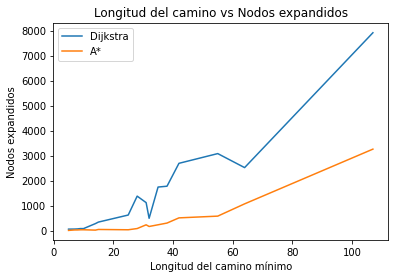

In [23]:
plt.plot(dic1.keys(), dic1.values(), label="Dijkstra")
plt.plot(dic2.keys(), dic2.values(), label="A*")
plt.xlabel("Longitud del camino mínimo")
plt.ylabel("Nodos expandidos")
plt.title("Longitud del camino vs Nodos expandidos")
plt.legend()
plt.show()